In [56]:
using Plots
using LinearAlgebra
using NumericalIntegration
using Distributions

In [57]:
using LaTeXStrings

# 1. Set the backend (GR is the default, fast, and handles this well)
gr()

# 2. Configure Global Settings for Retina + LaTeX Look
default(
    # Retina / High-DPI settings
    fmt = :png,         # PNG renders faster than SVG for complex plots
    dpi = 300,          # 300 DPI makes it crisp on Retina screens (standard is 72-100)
    
    # LaTeX Font settings
    fontfamily = "Computer Modern", # Use the standard LaTeX font
    guidefontsize = 12,             # Adjust font sizes for readability
    tickfontsize = 10,
    legendfontsize = 10
)

QUANTUM HARMONIC OSCILLATOR

In [ ]:
"""
N -- Number of eigenfunctions to compute

output shape is (length(x), N+1) and it returns the eigenvectors with quantum number from 0 to N
"""
function harmonic_wavefunction(x, N)
    f_1 = 0
    f0 = (1 / π^0.25) * exp.(-0.5 * x.^2)
    eigenfunctions = Array{Float64,2}(undef, length(x), N+2)
    eigenfunctions[:,2] .= f0
    eigenfunctions[:,1] .= f_1
    for i in 3:N+1
        eigenfunctions[:,i] .= sqrt(2 / (i-2)) * x .* eigenfunctions[:,i-1] - sqrt((i - 3) / (i-2)) * eigenfunctions[:,i-2] # Warning: i starts at 3 and therefore the normamization factor is adjusted to i-2
    end
    return eigenfunctions[:,2:end]
end

harmonic_wavefunction

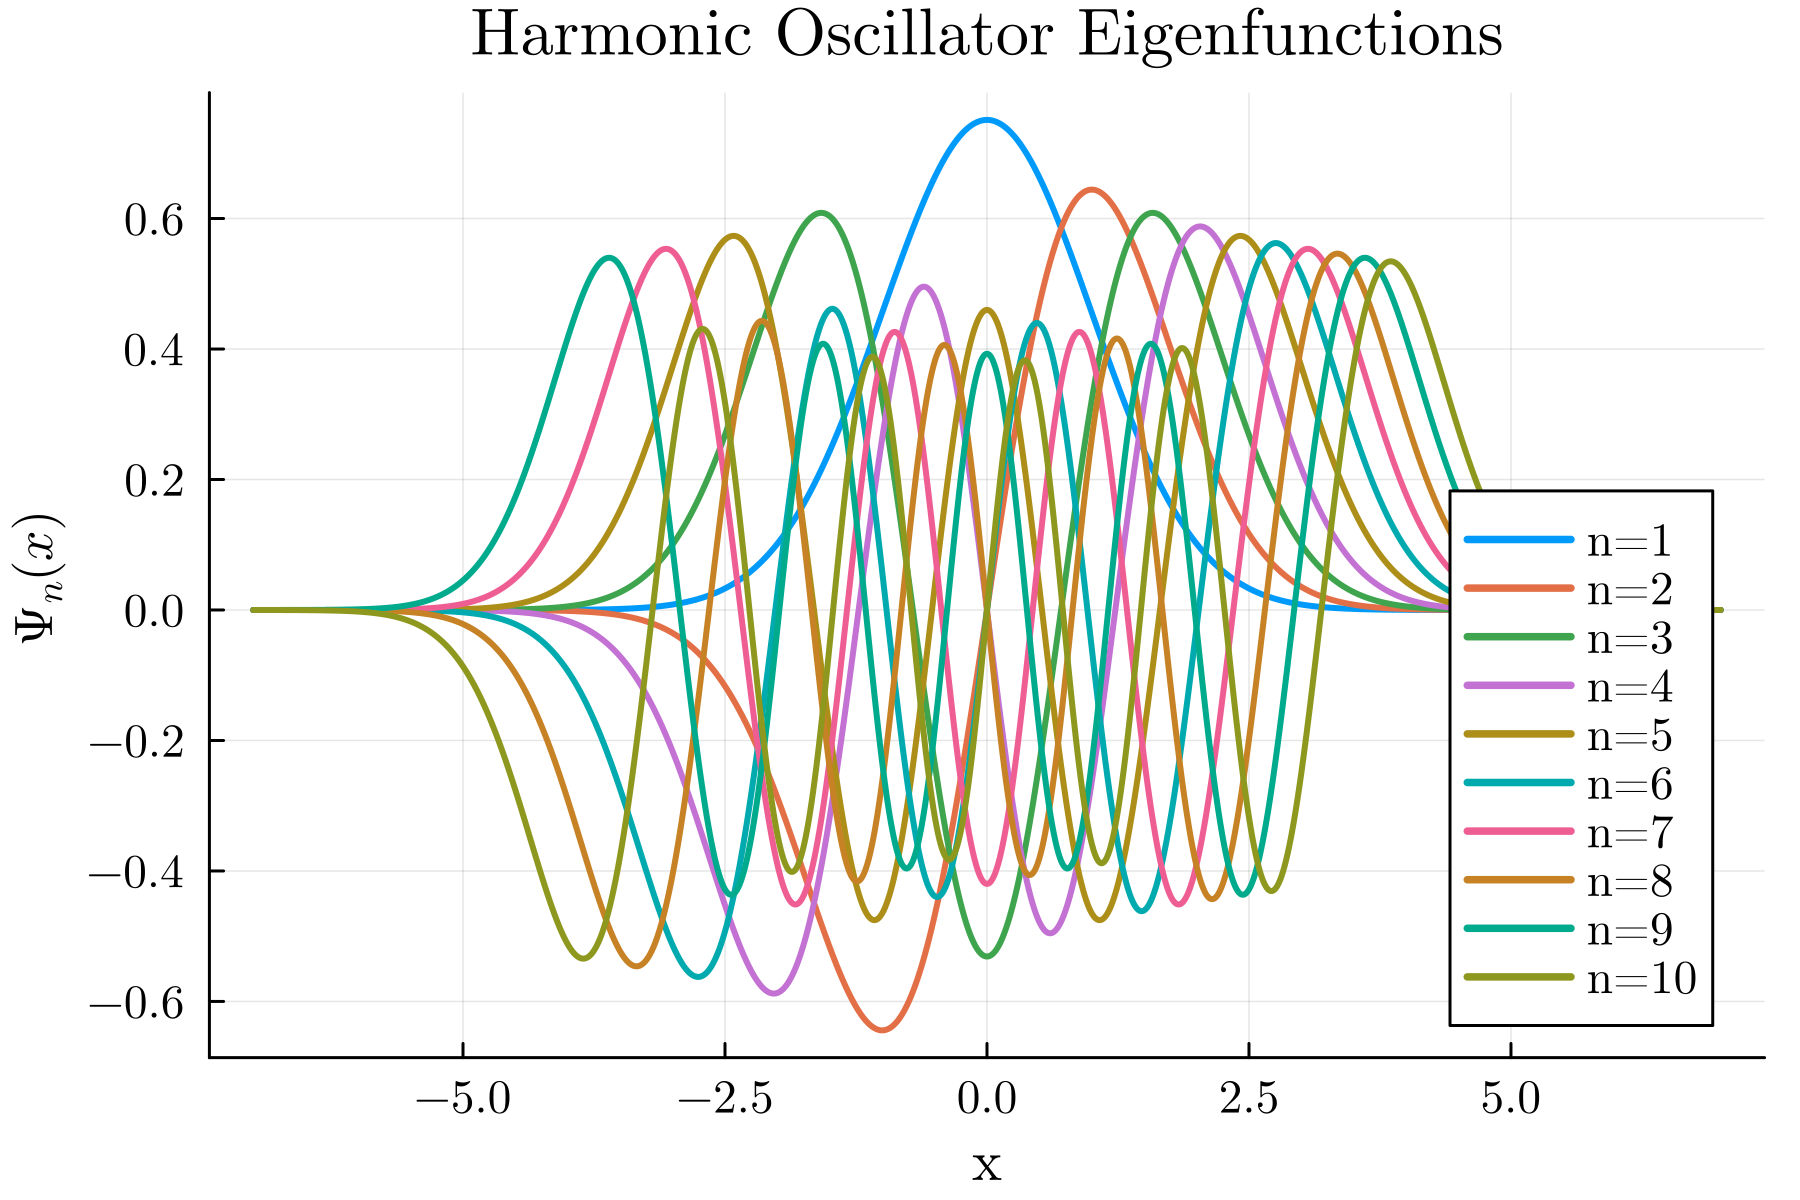

In [60]:
x = LinRange(-7, 7, 1000)
N = 10
eigenfunctions = harmonic_wavefunction(x, N)
plot()  # Create initial plot
for n in 1:N
    plot!(x, eigenfunctions[:,n], label="n=$n", lw=2)
end
plot!(title="Harmonic Oscillator Eigenfunctions", xlabel="x", ylabel=L"\Psi_n(x)")
display(plot!())

In [62]:
"""
psi - constructed to be coming from harmonic_wavefunction
n1, n2 - indices of the space points
"""
function harmonic_density(psi, E, n1, n2, beta)
    vec1 = psi[n1,:]
    vec2 = psi[n2,:]
    @assert length(vec1) == length(E) "Length mismatch between number of eigenfunctions and energy levels"
    energy = exp.(-beta.*E)
    return dot(vec2, vec1 .* energy)
end

harmonic_density

In [63]:
function diagonal_harmonic_density(psi, E, beta, x)
    N = length(x)
    density = zeros(N)
    for i in 1:N
        density[i] = harmonic_density(psi, E, i, i, beta)
    end
    return density
end

diagonal_harmonic_density (generic function with 1 method)

In [51]:
function compute_diagonal_density(x_grid, beta, N_max_limit)
    rho_diag = zeros(Float64, length(x_grid))
    Z = 0.0
    psis = harmonic_wavefunction(x_grid, N_max_limit)
    
    for n in 0:(N_max_limit-1)
        E_n = n + 0.5  # Harmonic oscillator energy (hbar*w = 1)
        
        weight = exp(-beta * (E_n - 0.5)) # This is exp(-beta * n)

        if weight < 1e-20
            println("Converged at n = $n")
            break
        end
        
        Z += weight
        
        psi_val = abs2.(psis[:, n+2]) # n=0 is at index 2 in your code
        if any(isinf.(psi_val))
            println("Warning: Wavefunction unstable at n=$n. Stopping sum.")
            break
        end
        
        rho_diag .+= weight * psi_val
    end
    
    return rho_diag ./ Z
end

compute_diagonal_density (generic function with 1 method)

In [68]:
function partition_function(psi, E, beta, x)
    integrande = diagonal_harmonic_density(psi, E, beta, x)
    method = SimpsonEven()
    return integrate(x, integrande, method)
end

partition_function (generic function with 3 methods)

In [70]:
function partition_function(beta, x)
    integrande = compute_diagonal_density(x, beta, 50)
    method = SimpsonEven()
    return integrate(x, integrande, method)
end

partition_function (generic function with 3 methods)

In [72]:
x = LinRange(-2, 2, 1000)
psi = harmonic_wavefunction(x, 20)
E = collect(0:20) .+ 0.5
beta = collect(0.5:0.5:2.0)

4-element Vector{Float64}:
 0.5
 1.0
 1.5
 2.0

In [73]:
for i in 1:length(beta)
    Z = partition_function(psi, E, beta[i], x)
    println("Partition function at beta=$(beta[i]) is Z=$Z")
end

Partition function at beta=0.5 is Z=1.6594761339805357
Partition function at beta=1.0 is Z=0.9072117377292939
Partition function at beta=1.5 is Z=0.5933317544336302
Partition function at beta=2.0 is Z=0.41968399295111436


Max density at beta=0.5 is 0.5526457033514124
Max density at beta=1.0 is 0.3680045169568822
Max density at beta=1.5 is 0.27339629724701664
Max density at beta=2.0 is 0.209480363988693


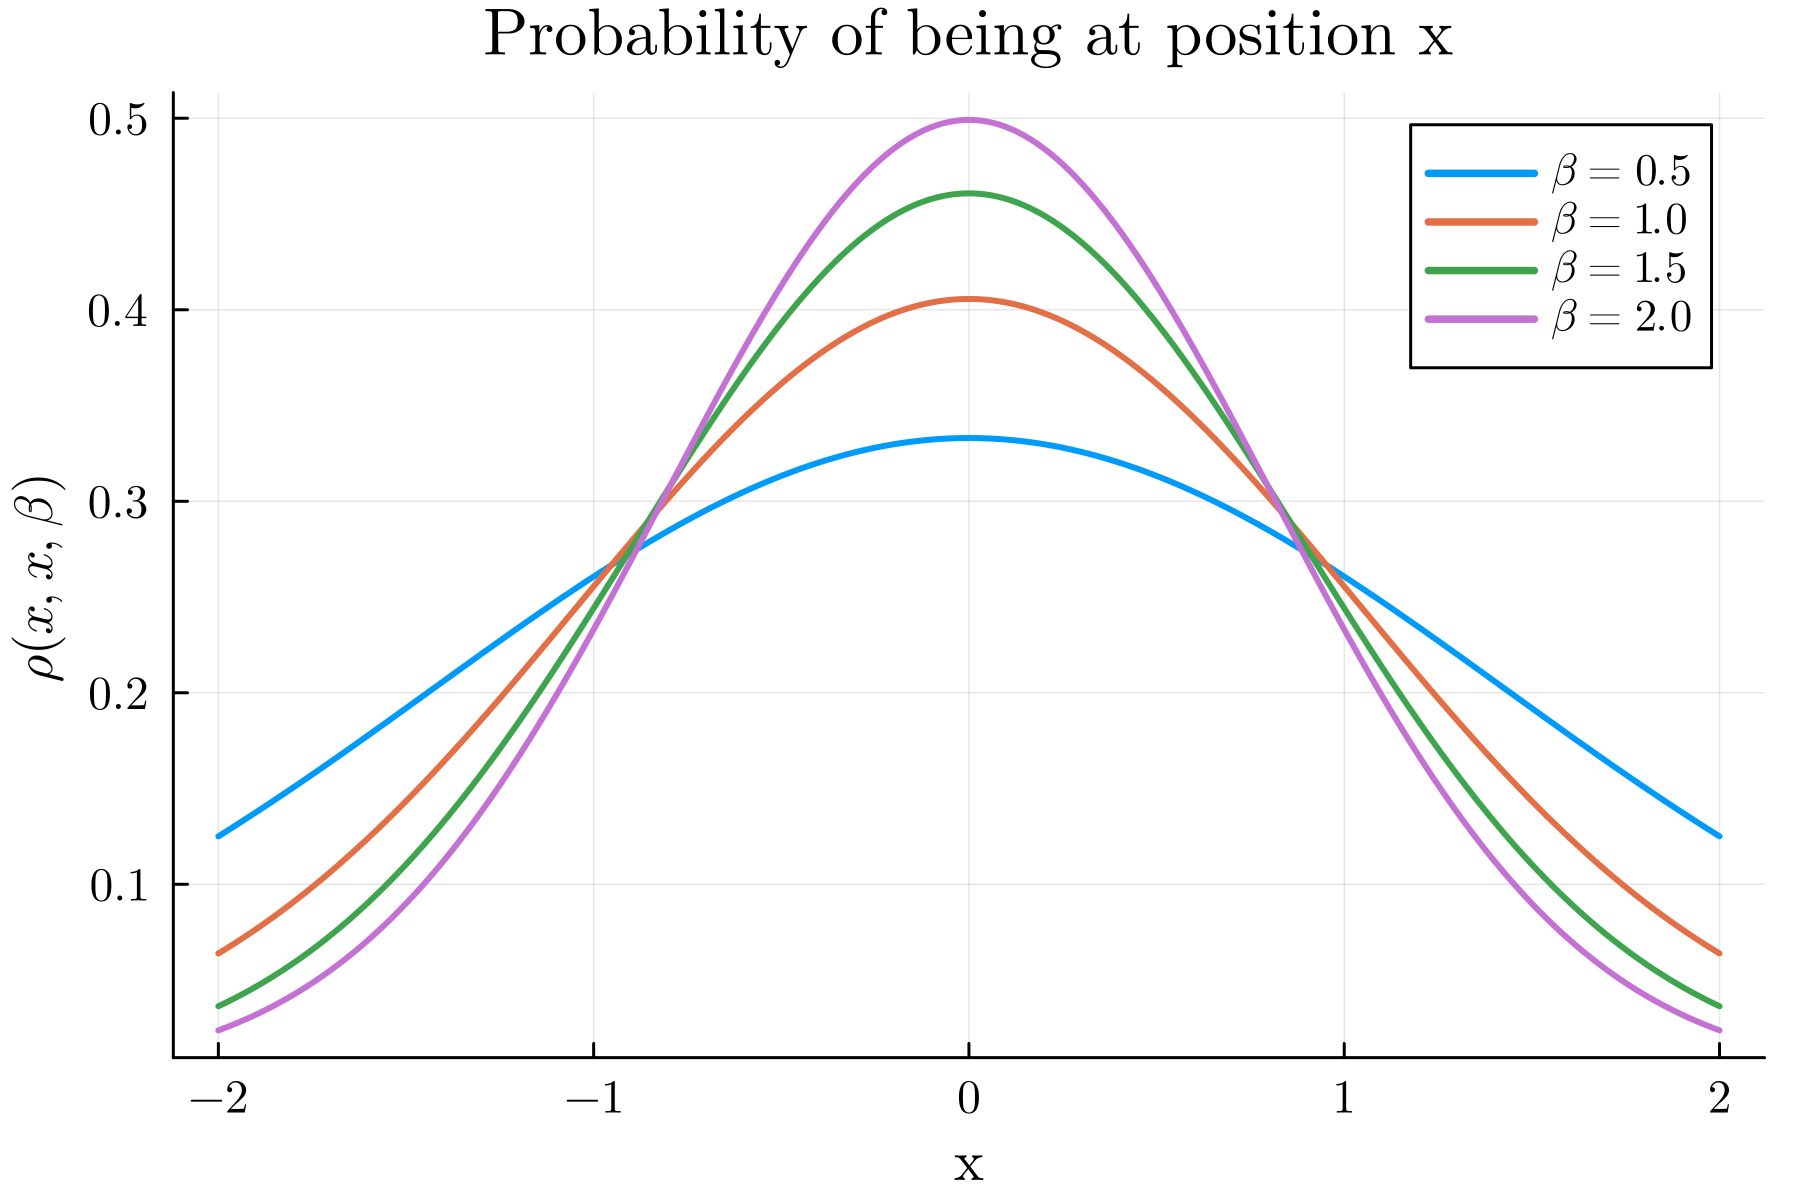

In [74]:
plot()
for i in 1:length(beta)
    density = diagonal_harmonic_density(psi, E, beta[i], x)
    println("Max density at beta=$(beta[i]) is $(maximum(density))")
    Z = partition_function(psi, E, beta[i], x)
    density ./= Z  # Normalize the density
    plot!(x, density, label=L"\beta=%$(beta[i])", lw=2)
end
plot!(title="Probability of being at position x", xlabel="x", ylabel=L"\rho(x, x, \beta)")
display(plot!())

HIGH TEMPERATURE LIMIT CONVOLUTION

In [75]:
"""
The space grid x is supposed to be evenly spaced with n points.
"""
function matrix_square(x, rho, n)
    dx = x[2] - x[1]
    rho = rho * dx
    return (rho^n)
end

matrix_square

In [76]:
function naive_harmonic_path(x, beta, delta, N_eigenvec)
    N_beads = length(x)
    y = copy(x)
    delta = beta/N_beads
    dist_bead = DiscreteUniform(1, N_beads)
    k = rand(dist_bead)
    dist_var = Uniform(-delta, delta)
    dist_ran = Uniform(0, 1)
    z = x[k] + rand(dist_var)
    y[k] = z
    E = collect(0:N_eigenvec) .+ 0.5
    count = 0

    phi = harmonic_wavefunction(y, N_eigenvec)
    psi = harmonic_wavefunction(x, N_eigenvec)
    pa = harmonic_density(psi, E, mod1(k-1, N_beads), k, beta)*harmonic_density(psi, E, k, mod1(k+1, N_beads), beta)*exp(-0.5*delta*x[k]^2)
    pb = harmonic_density(phi, E, mod1(k-1, N_beads), k, beta)*harmonic_density(phi, E, k, mod1(k+1, N_beads), beta)*exp(-0.5*delta*z^2)

    if rand(dist_ran) < pb/pa
        return y
    else
        return x
    end
end

naive_harmonic_path (generic function with 1 method)

In [77]:
function naive_QMC(p)
    N_steps = p.N_steps
    beta = p.beta
    delta = p.delta
    N_eigenvec = p.N_eigenvec
    x = p.initial_path
    n_beads = length(x)
    paths = zeros(N_steps, n_beads)
    current_path = copy(x)
    paths[1, :] .= current_path
    count = 0

    for step in 2:N_steps
        current_path = naive_harmonic_path(current_path, beta, delta, N_eigenvec)
        paths[step, :] .= current_path
        if paths[step, :] == paths[step-1, :]
            count += 1
        end
    end

    return paths, count
end

naive_QMC (generic function with 1 method)

In [78]:
my_initial_path = randn(8)

p = (
    N_steps = 1000000,
    N_eigenvec = 20,
    beta = 4.0,
    delta = 0.5,
    initial_path = my_initial_path
)

(N_steps = 1000000, N_eigenvec = 20, beta = 4.0, delta = 0.5, initial_path = [0.04499906836709897, 1.8420521188455943, -2.082237852785352, -0.1841658160981966, -2.2036741632102603, -0.4998316340212811, 0.25104514113416115, -1.6613636531004476])

In [79]:
hist, rejection = naive_QMC(p)

([0.04499906836709897 1.8420521188455943 … 0.25104514113416115 -1.6613636531004476; 0.04499906836709897 1.8420521188455943 … 0.5763488934672671 -1.6613636531004476; … ; 0.8535401349093461 0.5289430975807241 … 0.27181598104181115 -0.6309490944676127; 0.8535401349093461 0.5289430975807241 … 0.04604373702110809 -0.6309490944676127], 155865)

In [80]:
println("Rejection rate: $((rejection/p.N_steps)*100) %")

Rejection rate: 15.586500000000001 %


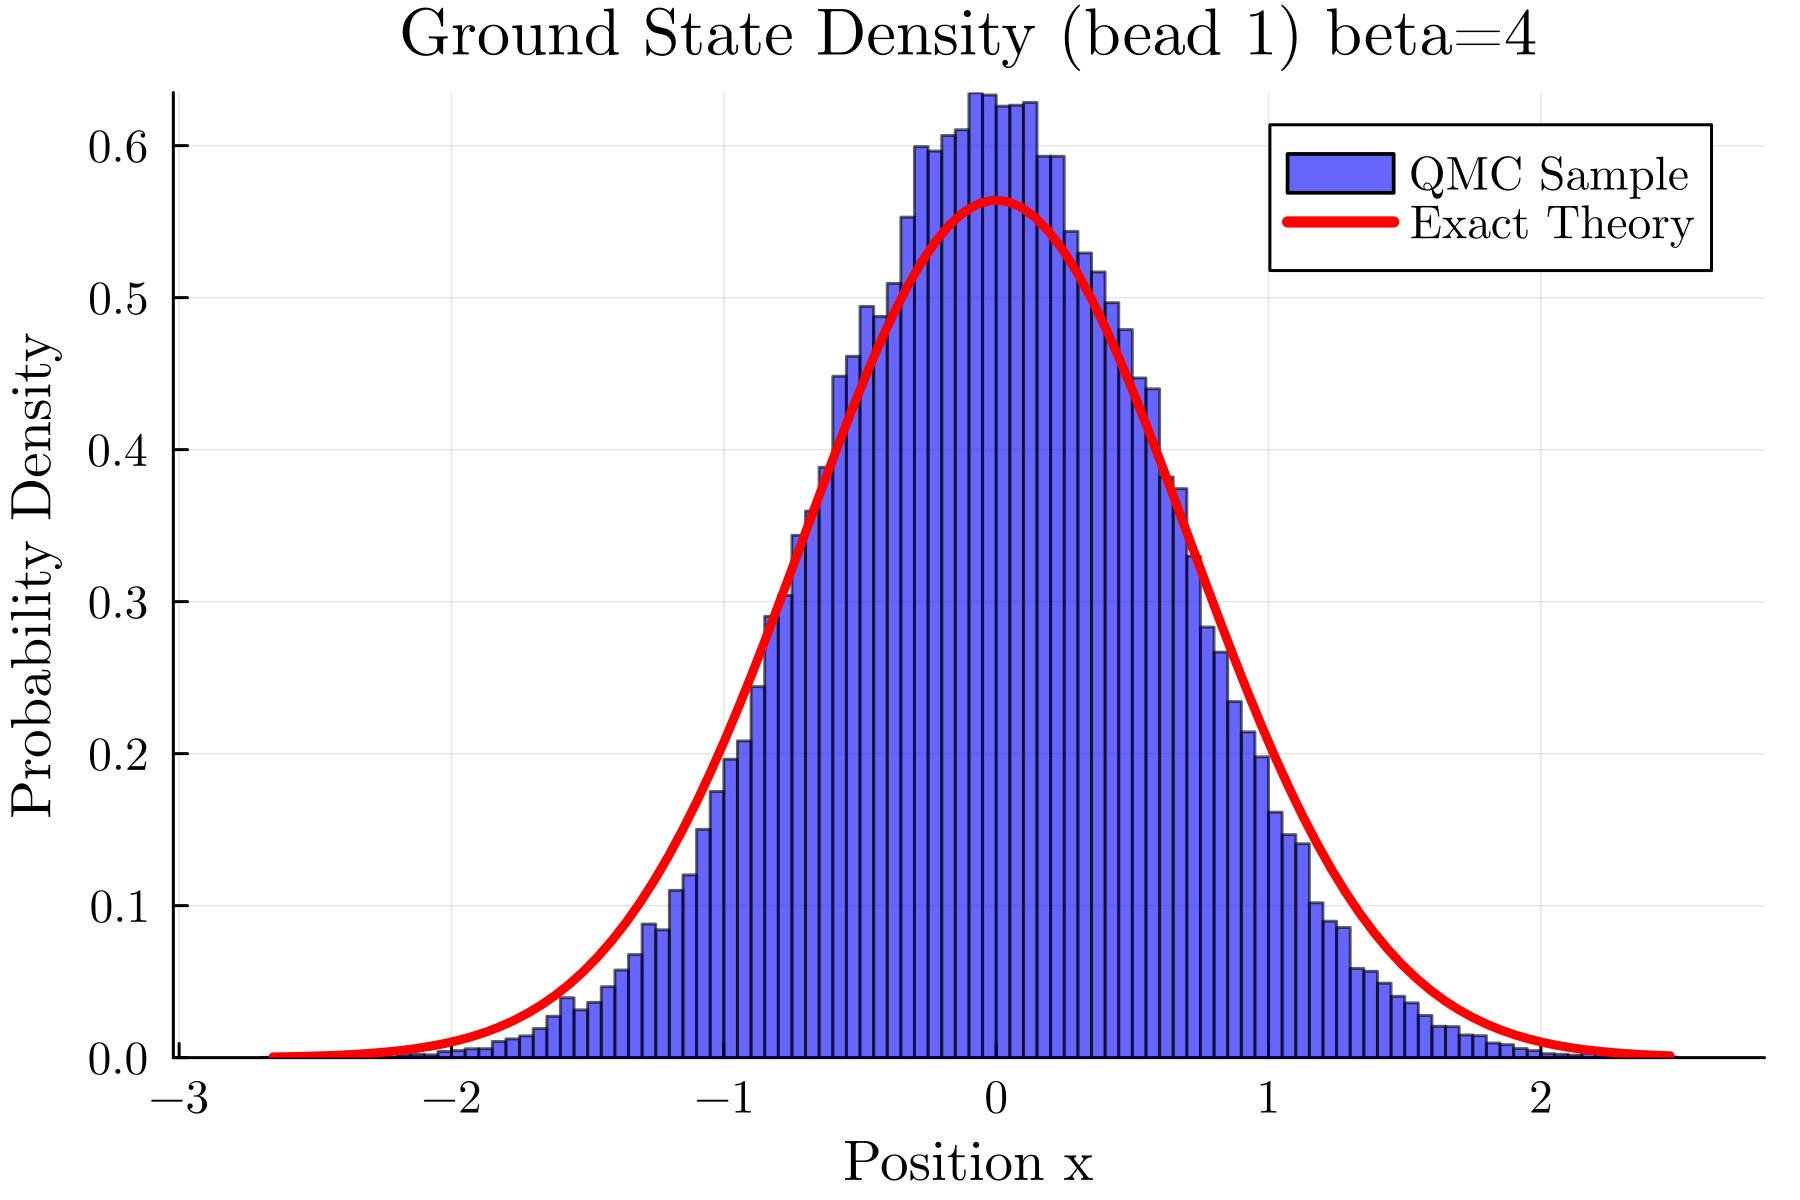

In [81]:
clean_history_x0 = hist[1000:end, 1]
histogram(clean_history_x0, 
    normalize = :pdf,       # Normalize area to 1 (to compare with theory)
    bins = 100,              # Number of bars
    label = "QMC Sample",
    color = :blue,
    alpha = 0.6,            # Transparency
    xlabel = "Position x",
    ylabel = "Probability Density",
    title = "Ground State Density (bead 1) beta=4"
)
x_grid = range(minimum(clean_history_x0), maximum(clean_history_x0), length=100)
psi_0(x) = (1/pi)^(1/4) * exp(-x^2 / 2)  # Standard Harmonic Oscillator ground state
plot!(x_grid, abs2.(psi_0.(x_grid)), 
    label = "Exact Theory", 
    lw = 3, 
    color = :red
)

DIRECT PATH SAMPLING AND THE LEVY CONSTRUCTION

In [82]:
function levy_free_path(start_bead, end_bead, N_beads, beta)
    step_time = beta/N_beads
    path = zeros(N_beads)
    path[1] = start_bead
    path[end] = end_bead

    for i in 2:N_beads-1
        delta = (N_beads-i)*step_time
        mean = (delta*path[i-1] + step_time*end_bead)/(delta + step_time)
        variance = (step_time*delta)/(step_time + delta)
        dist = Normal(mean, sqrt(variance))
        path[i] = rand(dist)
    end
    return path
end

levy_free_path (generic function with 1 method)

In [83]:
sample = levy_free_path(0.0, 0.0, 50000, 1.0)

50000-element Vector{Float64}:
  0.0
 -0.0008587360302721356
  0.007053623198340387
  0.0020013245206707488
  0.0047094281716122035
  0.0018893217962145403
  0.001920211966634965
  0.005079441408470846
  0.007827978889520075
  0.0025147007637638967
  0.002958496075138524
  0.003838116999479304
 -0.0025679616197866067
  ⋮
 -0.013332417060703313
 -0.008799040014668559
 -0.002199052778638875
 -0.007951823661740217
 -0.008605551732376246
 -0.008953021295403648
 -0.004599586163194909
 -0.004377863138682799
 -0.002696203477626597
 -0.0043004971328688925
 -0.0034480593413971175
  0.0

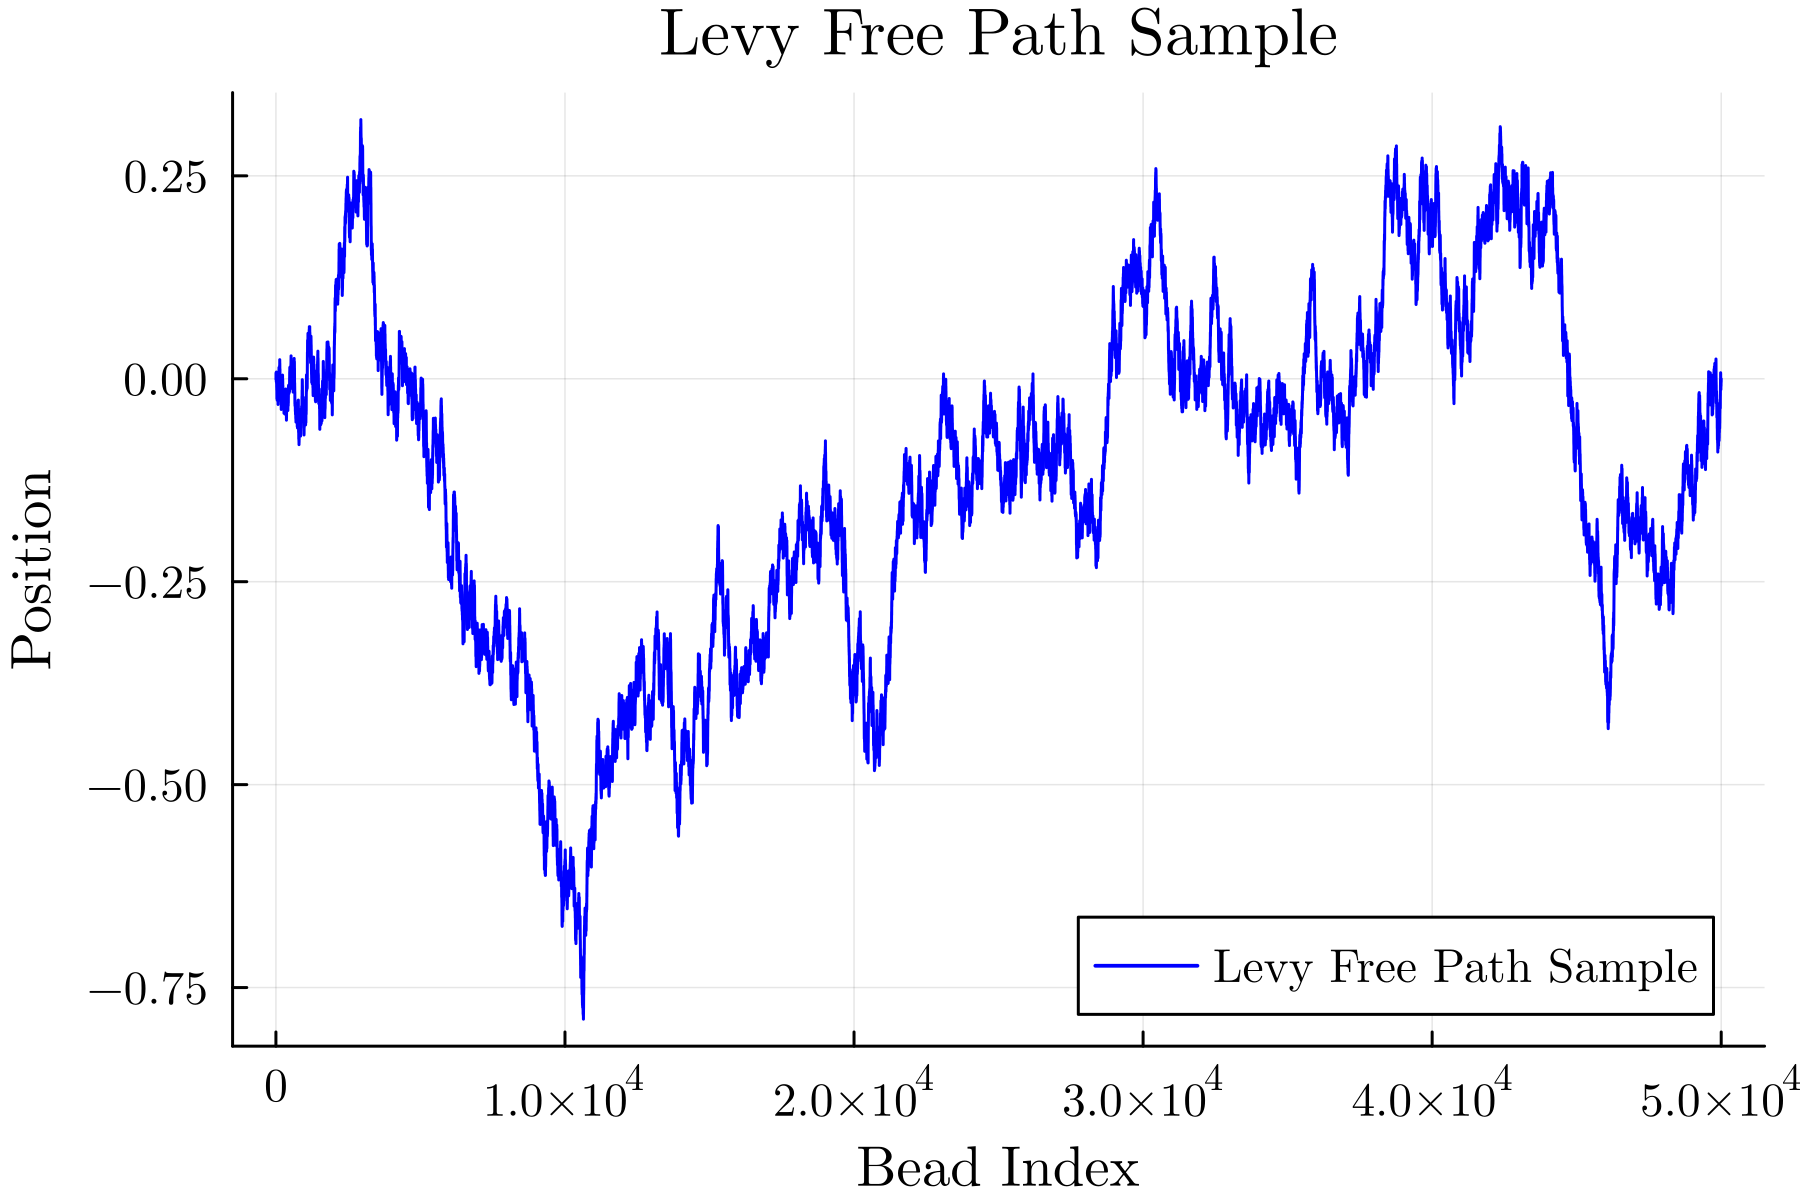

In [84]:
plot()
plot!(sample, lw=1, label="Levy Free Path Sample", color=:blue)
plot!(title="Levy Free Path Sample", xlabel="Bead Index", ylabel="Position")
display(plot!())    

In [85]:
function levy_harmonic_path(start_bead, end_bead, N_beads, beta)
    step_time = beta/N_beads
    path = zeros(N_beads)
    path[1] = start_bead
    path[end] = end_bead

    for i in 2:N_beads-1
        delta1 = coth(step_time*(N_beads - i)) + coth(step_time)
        delta2 = path[i-1]*csch(step_time*N_beads) + end_bead*csch(step_time*(N_beads - i))
        mean = delta2 / delta1
        variance = 1 / delta1
        dist = Normal(mean, sqrt(variance))
        path[i] = rand(dist)
    end
    return path
end
    

levy_harmonic_path (generic function with 1 method)

In [86]:
sample_harm = levy_harmonic_path(0.0, 0.0, 50000, 1.0)

50000-element Vector{Float64}:
  0.0
 -0.001457237043054019
  0.006624381054942726
 -0.0001611407820655496
  0.00042961306058781853
 -0.006066087873103183
  0.0018422204992272295
 -0.005311363632411953
  0.005483072612565958
  0.0010873993368000288
  0.0068935345063585
  0.0019169830479521407
 -0.0009192281075729252
  ⋮
 -0.004267027181193644
  0.0023397835596407853
  0.003682525516469156
 -0.0038354496666876776
 -0.0007404664922638998
 -0.002552967966502764
  0.0022593578426198537
  0.0019956369628531994
  0.006914100313638008
 -0.003624867522450747
  0.004747677881760603
  0.0

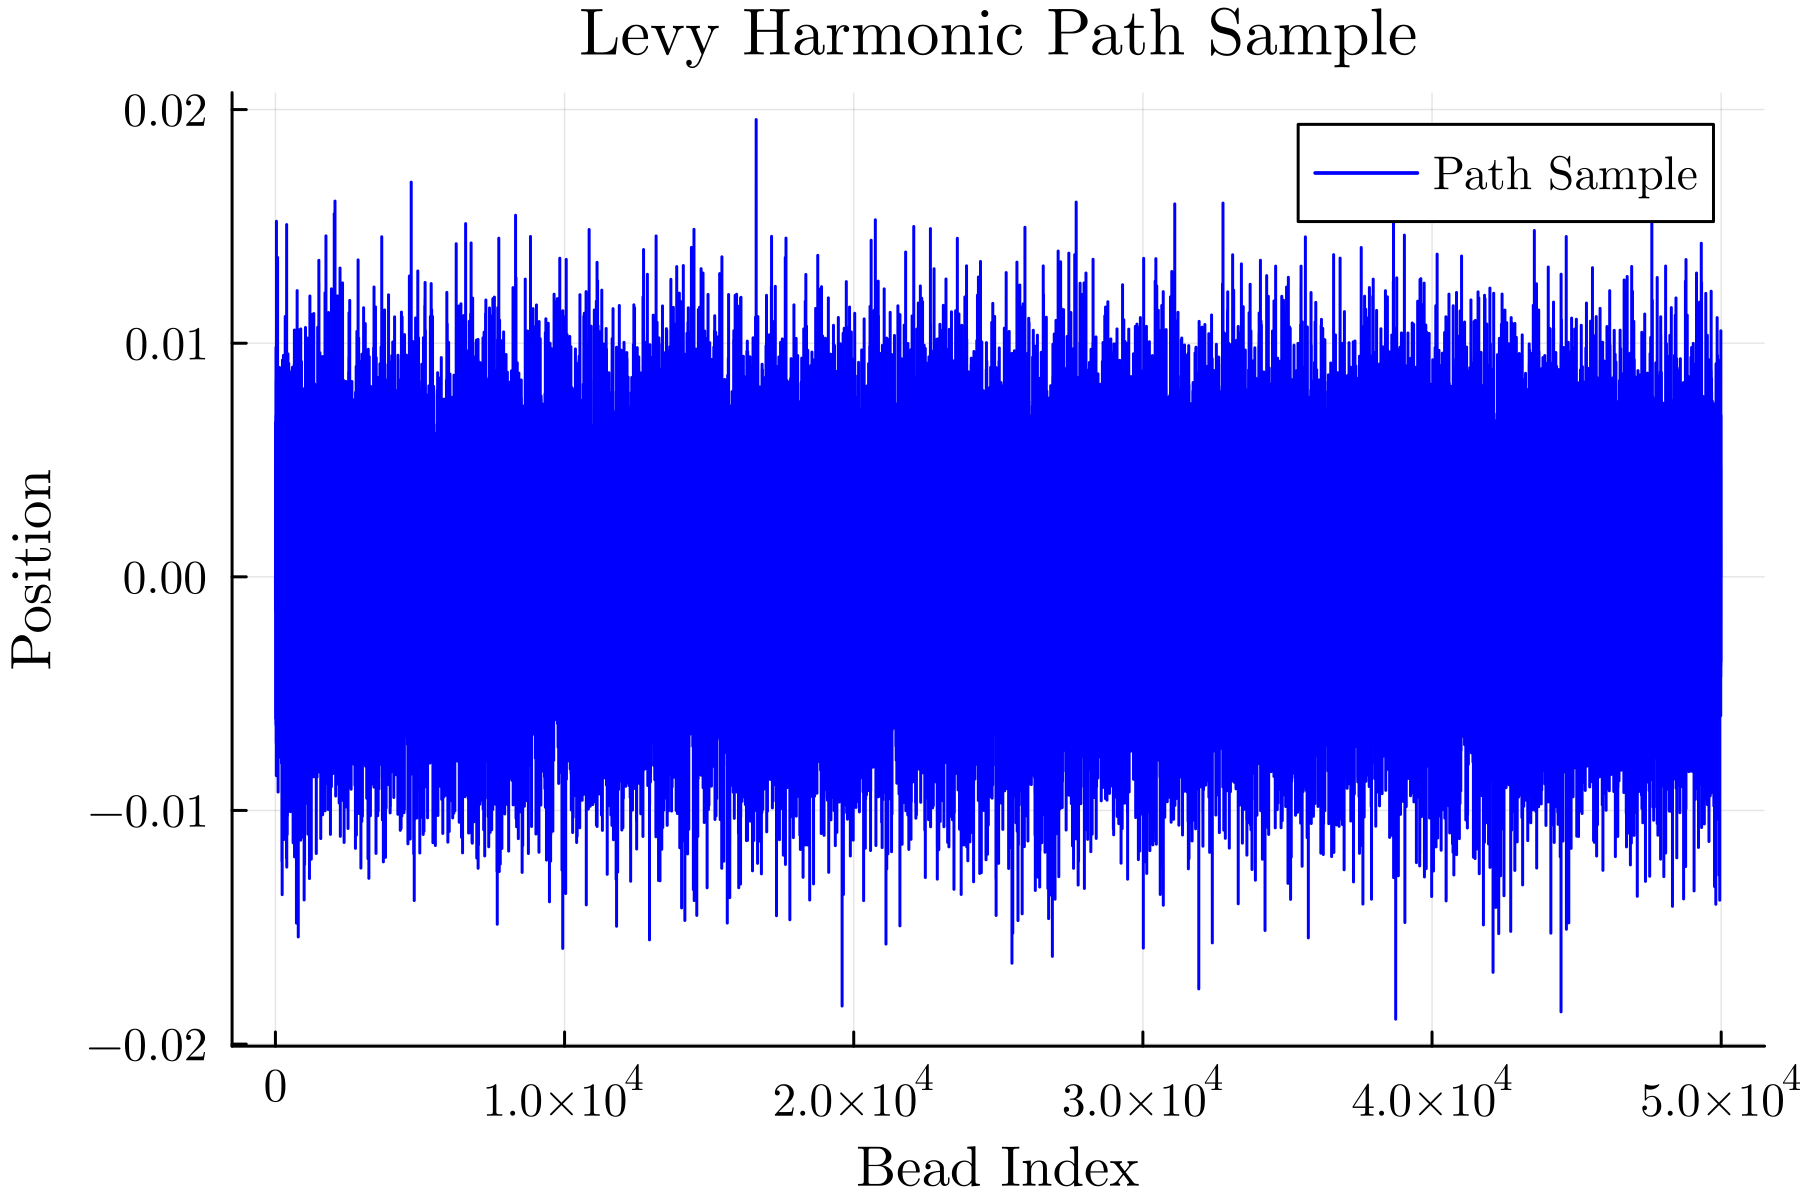

In [87]:
plot()
plot!(sample_harm, lw=1, label="Path Sample", color=:blue)
plot!(title="Levy Harmonic Path Sample", xlabel="Bead Index", ylabel="Position")
display(plot!())    

PERIODIC BOUNDARY CONDITIONS, PATHS IN A BOX

In [88]:
function naive_box_path(start_bead, end_bead, N_beads, beta, L)
    K = N_beads//2
    if N_beads % 2 != 0
        throw(ArgumentError("Number of beads should be divisible by 2, but got $N_beads"))
    end
    if abs(start_bead) > L/2 || abs(end_bead) > L/2
            throw(ArgumentError("Bead positions must be within the box of size L=$L"))
        end
    for i in 1:K
        delta_k = 2^i
        delta = beta/delta_k
        for j in 1:N_beads/delta_k
            pplus = (j+1)*delta_k
            pmoins = (j-1)*delta_k
            mean = (path[pmoins] + path[pplus]) / 2
            variance = 2/delta
            dist = Normal(mean, sqrt(variance))
            z = rand(dist)
            if z>L || z<0
                path[j*delta_k] = path[j*delta_k]
            else
                path[j*delta_k] = z
            end
        end
    end
    return path
end

naive_box_path (generic function with 1 method)

PATH IN FOURIER SPACE

In [89]:
function fourier_free_path(beta, N_beads)
    path = zeros(N_beads)
    coeffs = zeros(N_beads)
    for i in 1:N_beads
        var = 2*N_beads^2*sin(pi*i/(2*N_beads))^2
        coeffs[i] = (beta/var)^(1/2)*randn()
    end
    for k in 1:N_beads
        path[k] = sum(coeffs[j]*sin(pi*j*(k-1/2)/N_beads) for j in 1:N_beads)
    end
    return path
end

fourier_free_path (generic function with 1 method)

In [90]:
sample_tf = fourier_free_path(1.0, 50000)

50000-element Vector{Float64}:
  0.00014074062867166525
 -1.0511345294459568e-5
 -0.0011302453006441422
 -0.007759127879095236
 -0.021366515438109086
 -0.012815534389757128
 -0.014847562842809957
 -0.012964036848642481
 -0.014325766961493524
 -0.010222283180202633
 -0.009839093000657434
 -0.013980490876587254
 -0.020512286685860127
  ⋮
  0.025479985635514946
  0.031101506894620337
  0.03057483592390676
  0.02680159381717809
  0.021613866161591812
  0.017650449306908553
  0.01263069717254466
  0.009847393100631974
  0.008603396292806055
 -0.0002118929243684971
  0.0031815486547172893
  0.0004467820616069026

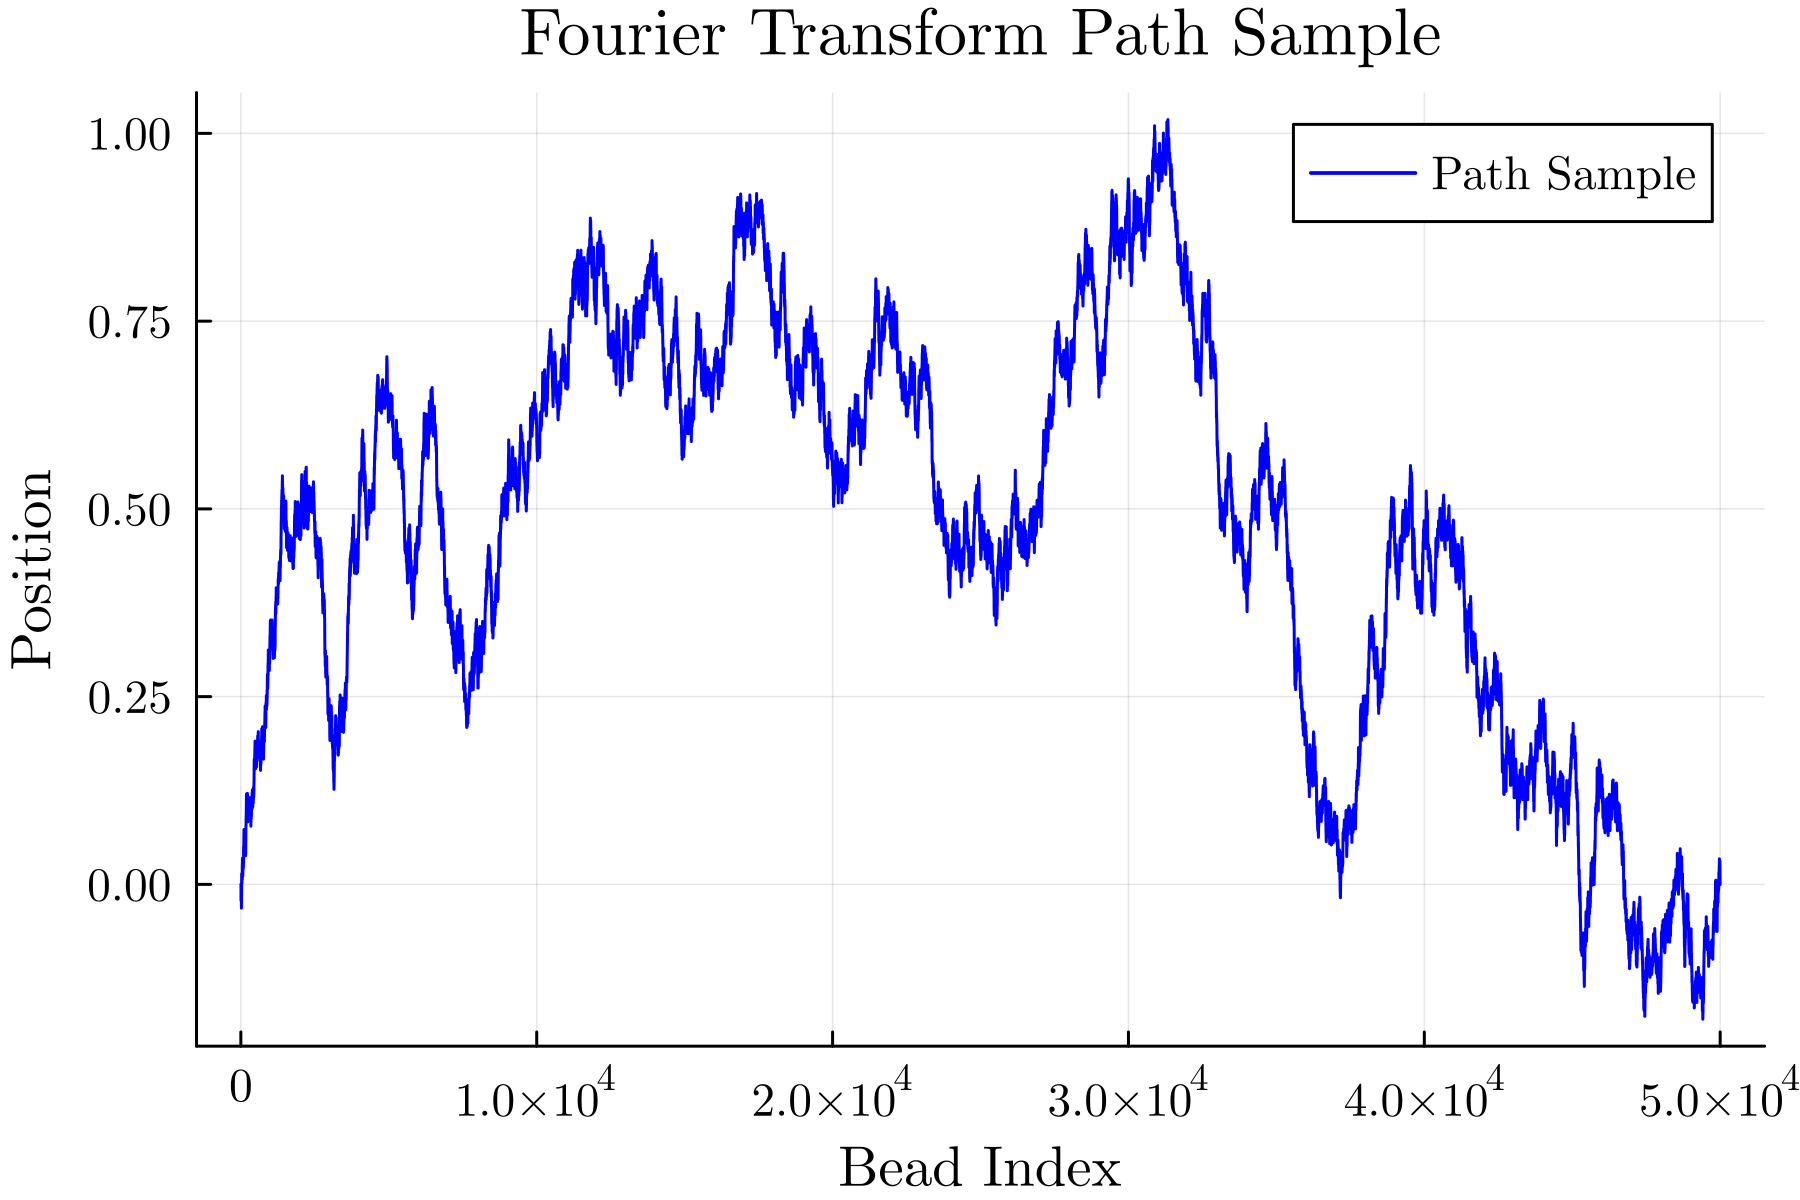

In [91]:
plot()
plot!(sample_tf, lw=1, label="Path Sample", color=:blue)
plot!(title="Fourier Transform Path Sample", xlabel="Bead Index", ylabel="Position")
display(plot!())   

CLASSICAL RANDOM PATH

In [92]:
function fourier_gen_path(N_beads, cutoff, roughness, L)
    A = []
    B = []
    path = []
    for i in 1:cutoff
        std = sqrt(1/(pi*i))*(L/(2*pi*i))^roughness
        push!(A, std*randn())
        push!(B, std*randn())
    end
    for i in collect(0:L/N_beads:L)
        sum = 0.0
        for j in 1:cutoff
            sum += A[j]*cos(2*pi*j*i/L) + B[j]*sin(2*pi*j*i/L)
        end
        push!(path, sum)
    end
    return path
end

fourier_gen_path (generic function with 1 method)

In [93]:
sample_rand = fourier_gen_path(50000, 40, 1.5, 1.0)

50001-element Vector{Any}:
 0.005014051212798109
 0.005016350874378157
 0.005018647692221621
 0.005020941665956638
 0.005023232795211798
 0.005025521079616285
 0.005027806518799963
 0.005030089112393518
 0.005032368860028591
 0.00503464576133785
 0.00503691981595515
 0.005039191023515646
 0.005041459383655892
 ⋮
 0.004988567355261527
 0.004990898273387818
 0.004993226351864573
 0.0049955515903226284
 0.004997873988392072
 0.0050001935457022004
 0.005002510261881695
 0.005004824136558882
 0.005007135169361557
 0.005009443359917325
 0.005011748707853672
 0.005014051212798106

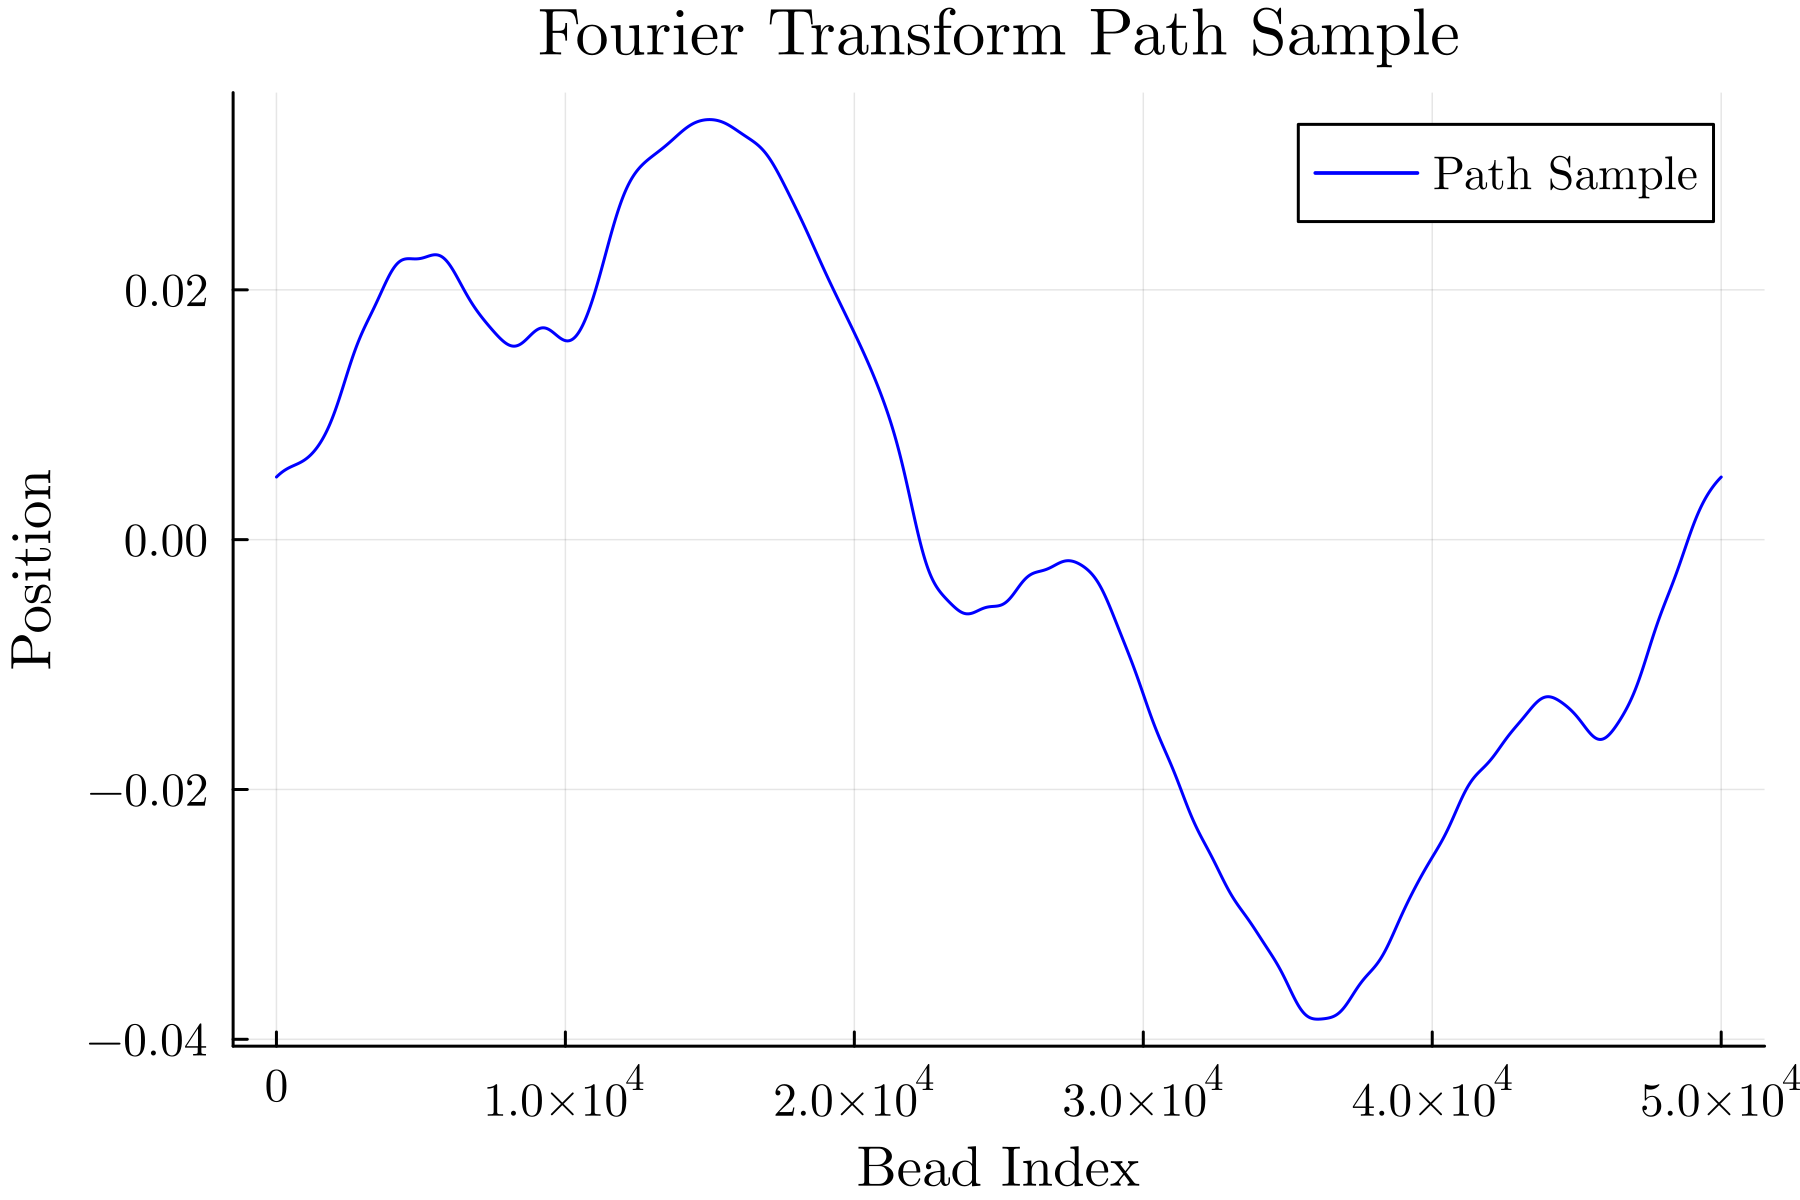

In [94]:
plot()
plot!(sample_rand, lw=1, label="Path Sample", color=:blue)
plot!(title="Fourier Transform Path Sample", xlabel="Bead Index", ylabel="Position")
display(plot!())   